# NEKA - Modelling
The objective is to say if a driver is tired or not, to avoid car accidents. The idea of this file is to preprocess face images to generate a model
 which is able to predict drowsiness.

## Imports

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import numpy as np
import cv2
# --- keras ---
from keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
# --- sklearn ---
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

## Load Data

Load the previously preprocessed images, for modelling in further code cells. Data will be loaded and split using the same function.

In [2]:
def load_images_from_folder(folder):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        label = folder.split("/")[-1]  # Extract class label from folder name
        
        if os.path.isfile(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = plt.imread(path)
            
            # Resize the image to a consistent size if needed
            # For example, you can use: img = cv2.resize(img, (desired_width, desired_height))
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [3]:
# Specify the paths to your image folders
class1_folder = "../../data/final/FinalDatasetCroppedAugmented/Awake"
class2_folder = "../../data/final/FinalDatasetCroppedAugmented/Tired"

# Load images and labels for each class
class1_images, class1_labels = load_images_from_folder(class1_folder)
class2_images, class2_labels = load_images_from_folder(class2_folder)

# Optionally, you can concatenate the arrays if needed
all_images = np.concatenate((class1_images, class2_images), axis=0)
all_labels = np.concatenate((class1_labels, class2_labels), axis=0)

# Print the shape of the arrays
print("Class 1 Images Shape:", class1_images.shape)
print("Class 2 Images Shape:", class2_images.shape)
print("All Images Shape:", all_images.shape)  

Class 1 Images Shape: (914, 128, 128, 3)
Class 2 Images Shape: (797, 128, 128, 3)
All Images Shape: (1711, 128, 128, 3)


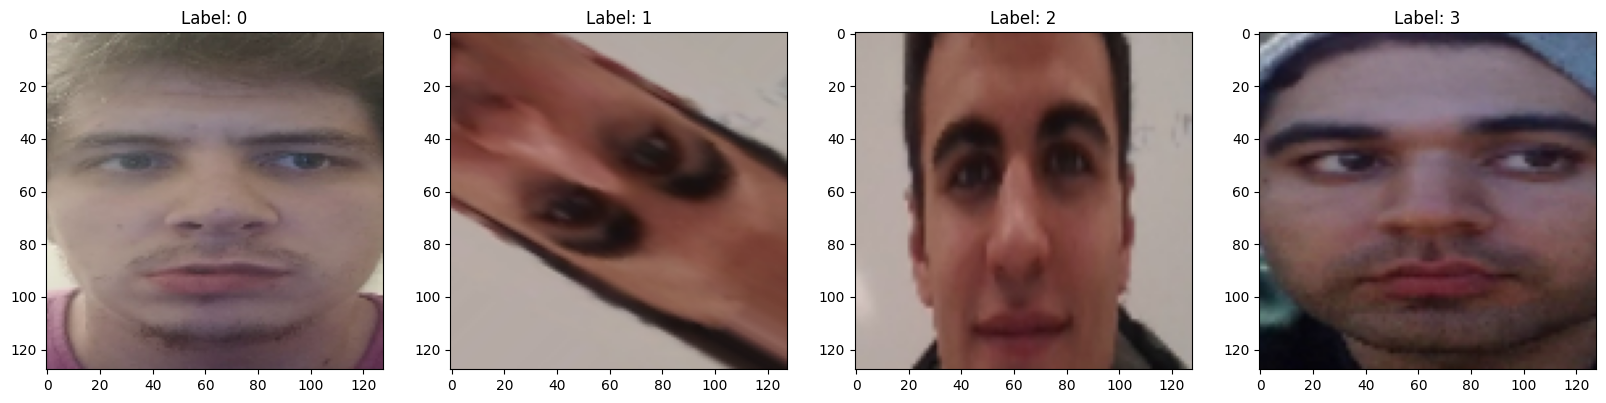

In [4]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()
plotting_images = np.random.choice(all_images.shape[0], size=4, replace=False)
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(all_images[plotting_images]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {idx}")  # Display label

## Normalization


In [5]:
all_images = all_images.astype(float)/255


## Modelling

### Cross validation

Test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

In [6]:
# Function to build the model (required for KerasClassifier)
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

    return model

In [7]:
# Convert the model to a scikit-learn compatible classifier
model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=32, verbose=1)

In [8]:
# CV configuration
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define the desired metric
scoring_metric = make_scorer(accuracy_score)

# use cross_validate to validate the model on the whole training set
cv_results = cross_validate(
    model,
    X=all_images,
    y=all_labels,
    cv=cv,
    scoring={'accuracy': scoring_metric},  # Puedes agregar más métricas según tus necesidades
    fit_params={'epochs': 10},
    return_train_score=False,
    return_estimator=False
)

C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
36/36 [==============================] - 14s 334ms/step - loss: 0.6587 - accuracy: 0.6070 - precision: 0.5604 - recall: 0.7250 - auc: 0.6796
Epoch 2/10
36/36 [==============================] - 12s 336ms/step - loss: 0.4218 - accuracy: 0.8325 - precision: 0.8441 - recall: 0.7853 - auc: 0.8956
Epoch 3/10
36/36 [==============================] - 15s 417ms/step - loss: 0.2985 - accuracy: 0.8772 - precision: 0.8654 - recall: 0.8719 - auc: 0.9466
Epoch 4/10
36/36 [==============================] - 18s 506ms/step - loss: 0.2577 - accuracy: 0.8833 - precision: 0.8699 - recall: 0.8814 - auc: 0.9593
Epoch 5/10
36/36 [==============================] - 14s 382ms/step - loss: 0.1838 - accuracy: 0.9193 - precision: 0.9197 - recall: 0.9058 - auc: 0.9797
Epoch 6/10
36/36 [==============================] - 14s 386ms/step - loss: 0.1675 - accuracy: 0.9316 - precision: 0.9187 - recall: 0.9360 - auc: 0.9829
Epoch 7/10
36/36 [==============================] - 20s 574ms/step - loss: 0.1432 - accu

C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
36/36 [==============================] - 20s 399ms/step - loss: 0.5563 - accuracy: 0.7011 - precision_1: 0.6994 - recall_1: 0.6297 - auc_1: 0.7810
Epoch 2/10
36/36 [==============================] - 14s 398ms/step - loss: 0.3746 - accuracy: 0.8361 - precision_1: 0.8165 - recall_1: 0.8365 - auc_1: 0.9128
Epoch 3/10
36/36 [==============================] - 15s 405ms/step - loss: 0.3039 - accuracy: 0.8720 - precision_1: 0.8755 - recall_1: 0.8459 - auc_1: 0.9435
Epoch 4/10
36/36 [==============================] - 15s 411ms/step - loss: 0.2220 - accuracy: 0.9001 - precision_1: 0.8899 - recall_1: 0.8966 - auc_1: 0.9699
Epoch 5/10
36/36 [==============================] - 16s 440ms/step - loss: 0.1902 - accuracy: 0.9264 - precision_1: 0.9358 - recall_1: 0.9041 - auc_1: 0.9780
Epoch 6/10
36/36 [==============================] - 16s 455ms/step - loss: 0.1449 - accuracy: 0.9351 - precision_1: 0.9354 - recall_1: 0.9248 - auc_1: 0.9872
Epoch 7/10
36/36 [==============================] - 

C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
36/36 [==============================] - 16s 387ms/step - loss: 0.6470 - accuracy: 0.6337 - precision_2: 0.6165 - recall_2: 0.5631 - auc_2: 0.6938
Epoch 2/10
36/36 [==============================] - 12s 338ms/step - loss: 0.4166 - accuracy: 0.8124 - precision_2: 0.8176 - recall_2: 0.7684 - auc_2: 0.8923
Epoch 3/10
36/36 [==============================] - 12s 346ms/step - loss: 0.3239 - accuracy: 0.8729 - precision_2: 0.8561 - recall_2: 0.8738 - auc_2: 0.9360
Epoch 4/10
36/36 [==============================] - 14s 386ms/step - loss: 0.2711 - accuracy: 0.8826 - precision_2: 0.8724 - recall_2: 0.8757 - auc_2: 0.9549
Epoch 5/10
36/36 [==============================] - 13s 366ms/step - loss: 0.2265 - accuracy: 0.9010 - precision_2: 0.8973 - recall_2: 0.8889 - auc_2: 0.9680
Epoch 6/10
36/36 [==============================] - 14s 376ms/step - loss: 0.1964 - accuracy: 0.9097 - precision_2: 0.9023 - recall_2: 0.9040 - auc_2: 0.9765
Epoch 7/10
36/36 [==============================] - 

In [9]:
# Print results
print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
print("Accuracy std:", np.std(cv_results['test_accuracy']))

Mean Accuracy: 0.8772636494915046
Accuracy std: 0.010826680308262058


### Train Final CNN Using Dropout

In [10]:
ModeloFinalCNN2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # Adds a convolution layer with 32 filters of size 3x3, activated by the ReLU activation function.
    tf.keras.layers.MaxPooling2D(2, 2), # Adds a Max Pooling layer to reduce the spatial dimensionality of the convolutional layer output.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(), # This layer flattens the output of the last convolution layer (transforming it into a one-dimensional vector) to prepare it for the densely connected layers.
    tf.keras.layers.Dropout(0.5), # Adds a Dropout layer to help prevent overfitting, randomly deactivating 50% of the neurons during training.
    tf.keras.layers.Dense(256, activation='relu'), # A dense layer with 256 neurons and ReLU activation.
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer with a single neuron and sigmoid activation, commonly used for binary classification problems.
])

In [11]:
# Define a mapping dictionary
class_mapping = {'Awake': 0, 'Tired': 1}

# Use the mapping function to convert string labels to numerical labels
numerical_labels = np.array([class_mapping[label] for label in all_labels])

# Print the result
print("Original Labels:", all_labels)
print("Numerical Labels:", numerical_labels)

Original Labels: ['Awake' 'Awake' 'Awake' ... 'Tired' 'Tired' 'Tired']
Numerical Labels: [0 0 0 ... 1 1 1]


In [12]:
ModeloFinalCNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history = ModeloFinalCNN2.fit(all_images, numerical_labels, epochs=10, batch_size=32) 
# During the training process, in each epoch, the imgTrain generator will generate batches of augmented images and their corresponding labels to train your model. This allows the model to be trained on the dynamically augmented images at each epoch, thus improving its ability to generalize from variations of the original images.

# imgTrain: It is the data flow generator you created with data augmentation

# epochs=10: Indicates the number of times the entire training data set will be passed back and forth through the neural network during training.

# batch_size=32: Specifies the number of samples used in each training iteration. The model is updated after each batch. In this case, a lot size of 32 is used.

# validation_data=validation_set: The validation data set is provided here to evaluate the performance of the model on data not used in training. This helps monitor whether the model is overfitting or generalizing well.

Epoch 1/10
54/54 [==============================] - 20s 344ms/step - loss: 0.6456 - accuracy: 0.6511 - precision_3: 0.6285 - recall_3: 0.6136 - auc_3: 0.7189
Epoch 2/10
54/54 [==============================] - 18s 340ms/step - loss: 0.4169 - accuracy: 0.8136 - precision_3: 0.8221 - recall_3: 0.7654 - auc_3: 0.8949
Epoch 3/10
54/54 [==============================] - 18s 341ms/step - loss: 0.3084 - accuracy: 0.8814 - precision_3: 0.8694 - recall_3: 0.8770 - auc_3: 0.9427
Epoch 4/10
54/54 [==============================] - 19s 343ms/step - loss: 0.2448 - accuracy: 0.8925 - precision_3: 0.8865 - recall_3: 0.8821 - auc_3: 0.9634
Epoch 5/10
54/54 [==============================] - 20s 364ms/step - loss: 0.1815 - accuracy: 0.9217 - precision_3: 0.9234 - recall_3: 0.9072 - auc_3: 0.9800
Epoch 6/10
54/54 [==============================] - 21s 387ms/step - loss: 0.1896 - accuracy: 0.9141 - precision_3: 0.9167 - recall_3: 0.8971 - auc_3: 0.9776
Epoch 7/10
54/54 [==============================] - 

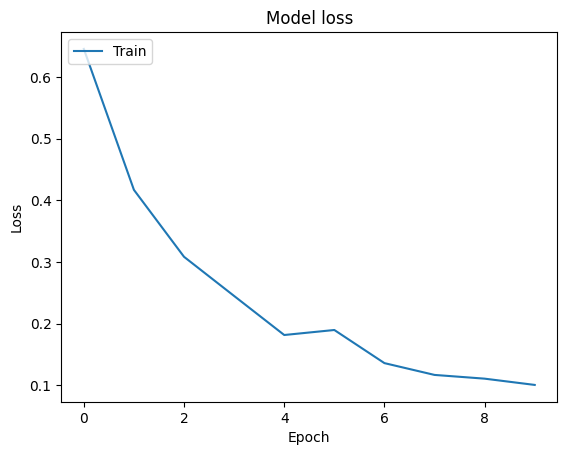

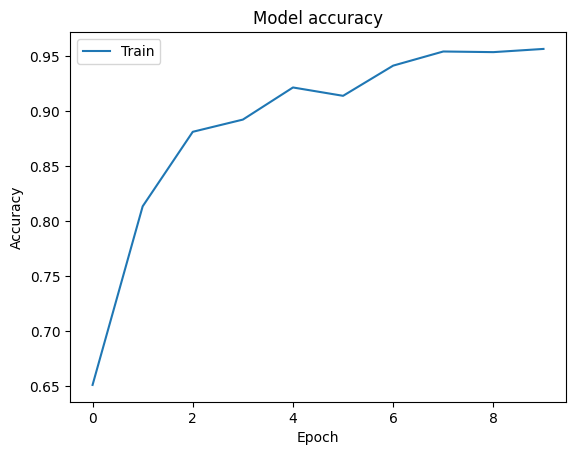

In [13]:
#Loss
plt.plot(history.history['loss']) 
#plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
#Accuracy

plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Validation

### Apply Preprocessing To Test Set
Load the test data


In [14]:
# Specify the paths to your image folders
class1_test_folder = "../../data/raw/FinalDatasetTrainTest/test/Awake"
class2_test_folder = "../../data/raw/FinalDatasetTrainTest/test/Tired"

# Load images and labels for each class
class1_test_images, class1_test_labels = load_images_from_folder(class1_test_folder)
class2_test_images, class2_test_labels = load_images_from_folder(class2_test_folder)

# Optionally, you can concatenate the arrays if needed
all_test_images = np.concatenate((class1_test_images, class2_test_images), axis=0)
all_test_labels = np.concatenate((class1_test_labels, class2_test_labels), axis=0)

# Print the shape of the arrays
print("Class 1 Test Images Shape:", class1_test_images.shape)
print("Class 2 Test Images Shape:", class2_test_images.shape)
print("All Test Images Shape:", all_test_images.shape)  

Class 1 Test Images Shape: (206, 256, 256, 3)
Class 2 Test Images Shape: (202, 256, 256, 3)
All Test Images Shape: (408, 256, 256, 3)


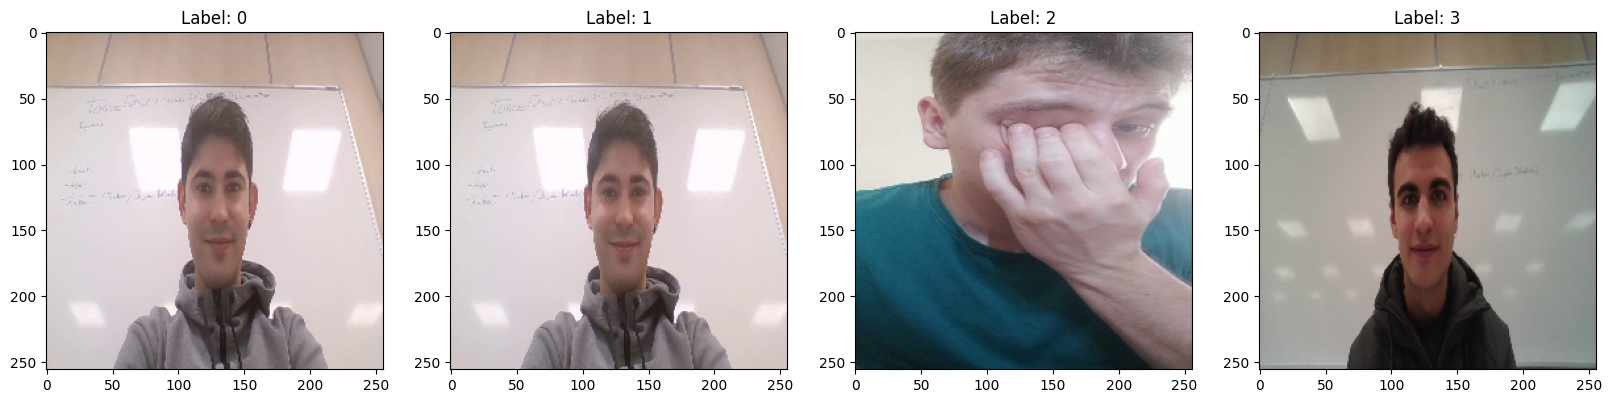

In [15]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()
plotting_images = np.random.choice(all_test_images.shape[0], size=4, replace=False)
fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) 
for idx, img in enumerate(all_test_images[plotting_images]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {idx}")  # Display label

Define preprocessing images (these are available on scripts/preprocessing.py)

In [16]:
NEW_IMAGE_SIZE = (128, 128)
HAAR_CASCADE_MODEL_PATH = '../../models/haarcascade_frontalface_alt2.xml'

def load_face_cascade(path):
    face_cascade = cv2.CascadeClassifier(path)
    if face_cascade.empty():
        print("Error loading Haar Cascade classifier.")
    else:
        print("Haar Cascade classifier loaded successfully.")

    return face_cascade

def apply_haar_cascade_on_image(image, face_cascade):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    # apply algorithm
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

    if len(faces) > 0:
        # Draw a rectangle around the main face and crop this
        (x, y, w, h) = faces[0]
        # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        detected_face = image[y:y + h, x:x + w]
    else:
        detected_face = None

    return detected_face


def apply_haar_cascade_on_images(images, face_cascade):
    cropped_images = np.random.random((images.shape[0], NEW_IMAGE_SIZE[0], NEW_IMAGE_SIZE[1], 3))
    miscropped_images = 0
    
    for idx, image in enumerate(images):

        detected_face = apply_haar_cascade_on_image(image, face_cascade)

        if detected_face is not None:
            cropped_images[idx] = np.array(cv2.resize(image, NEW_IMAGE_SIZE))
        else:
            miscropped_images += 1
            cropped_images[idx] = np.array(cv2.resize(image, NEW_IMAGE_SIZE))

    return miscropped_images, cropped_images

Finally, apply preprocessing.

In [20]:
all_test_labels

array(['Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake', 'Awake',
       'Awake', 'Awa

In [17]:
face_cascade = load_face_cascade(HAAR_CASCADE_MODEL_PATH) 
miscropped_images, all_test_images_cropped = apply_haar_cascade_on_images(all_test_images, face_cascade)

print("All Test Cropped Images Shape:", all_test_images_cropped.shape)
print("All MisCropped Test Images:", miscropped_images)

Haar Cascade classifier loaded successfully.
All Test Cropped Images Shape: (408, 128, 128, 3)
All MisCropped Test Images: 50


In [1]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()
plotting_images = np.random.choice(all_test_images_cropped.shape[0], size=4, replace=False)

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(all_test_images_cropped[:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {ModeloFinalCNN2.predict(img)}, {all_test_labels[idx]}")  # Display label

NameError: name 'np' is not defined

### Validate On Test Set

Raw predictions.

In [19]:
y_pred = ModeloFinalCNN2.predict(all_test_images_cropped)

print(np.concatenate((np.round(y_pred.reshape(len(y_pred), 1)), all_test_labels.reshape(len(all_test_labels), 1)), axis=1))

13/13 [==============================] - 2s 120ms/step
[['1.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'Awake']
 ['1.0' 'A

Confussion Matrix.

In [24]:
threshold = 0.5  # ajusta el umbral según tus necesidades
y_pred_binary = np.where(y_pred > threshold, 1, 0)

cm = confusion_matrix(all_test_labels.astype(np.int_), y_pred_binary)
print(cm)
accuracy = accuracy_score(all_test_labels.astype(np.int_), y_pred_binary)
print("Accuracy:", accuracy)

ValueError: invalid literal for int() with base 10: 'Awake'

## Save Final Model

In [107]:
ModeloFinalCNN2.save('../../models/01NekaFinalModel.h5') # To save model --->.h5 format
ModeloFinalCNN2.save_weights('../../models/01NekaFinalModelWeights.h5') # This does not save the architecture or configuration of the model, only the numerical values of the weights that have been learned during training.

print('Model Saved')

Model Saved


C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Additional Information

### Weights

 En una CNN, los pesos son matrices numéricas que representan la importancia y la relación entre las diferentes características (como bordes, texturas, etc.) presentes en las imágenes o datos de entrada.

Los pesos se utilizan en las capas de la red neuronal para realizar operaciones matemáticas en los datos de entrada y producir salidas que se acerquen lo más posible a las salidas deseadas. Estos pesos son ajustados iterativamente durante el entrenamiento para minimizar la diferencia entre las predicciones del modelo y las etiquetas reales de los datos de entrenamiento.